# Time-frequency analysis of grand LFP mean

Here, we take the mean across all (normalized) channels across all subjects of the peri-event LFP response.

In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio

%matplotlib inline
np.random.seed(12346)

/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from time_frequency_helpers import *

In [3]:
# data location
dbname = 'data/bart.hdf5'

# get list of (patient, dataset) tuples to plot
dsets = pd.read_csv('data/lfp_channel_file.csv', header=None).iloc[:, :2].drop_duplicates()

In [4]:
Tpre = -2.5
Tpost = 1.5
freqs = np.exp(np.linspace(np.log(2.5), np.log(50)))
niter = 100
thresh = (0.025, 0.975)
clim = (-3, 3)
baseline_interval = (-6, 5)  # (-1.5, -1.35)
nf = Normalizer(baseline_interval) #phys.norm_by_mean(baseline_interval)

In [5]:
tuplist = [tuple(d) for _, d in dsets.iterrows()]

# Contrast stops - pops

In [6]:
%%time
spectra, labels, taxis, faxis = get_spectra_and_labels(dbname, tuplist,
                                    ['stops', 'pops'], Tpre, Tpost, freqs, normfun=nf)

CPU times: user 4.09 s, sys: 2.95 s, total: 7.04 s
Wall time: 1h 39min 58s
(11, 1)
(12, 1)
(14, 1)
(14, 2)
(15, 1)
(16, 1)
(17, 1)
(16, 2)
(17, 2)(21, 1)(20, 1)(18, 1)(24, 1)(22, 1)





(25, 1)(23, 1)

(30, 1)


In [7]:
ss = np.array(spectra)
img0 = np.mean(ss[labels == 0], axis=0)
img1 = np.mean(ss[labels == 1], axis=0)
cont = img0/img1

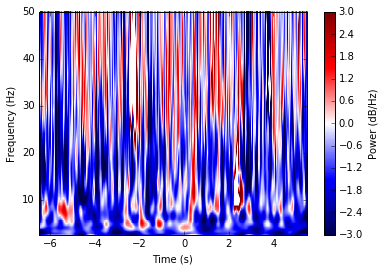

In [8]:
plt.figure(figsize=(10, 10))
T = len(taxis)
make_plot(cont, taxis, faxis, rasterized=True, cmap='seismic', clim=clim);

CPU times: user 18min 33s, sys: 5min 25s, total: 23min 58s
Wall time: 2h 2min 16s
(11, 1)
(12, 1)
(14, 1)
(14, 2)
(15, 1)
(16, 1)
(16, 2)
(17, 1)
(17, 2)(21, 1)(20, 1)(18, 1)(24, 1)(22, 1)





(25, 1)(23, 1)

(30, 1)


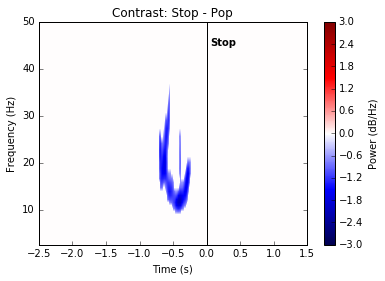

In [9]:
%%time

contrast0, fig = significant_time_frequency(dbname, tuplist, ['stops', 'pops'], 
                                           Tpre, Tpost,
                                           freqs, thresh, normfun=nf, niter=niter, 
                                           rasterized=True, cmap='seismic', clim=clim);

# decorations
plt.axvline(x=0, color='k')
plt.text(0.05, 45, 'Stop', fontweight='bold')

plt.title('Contrast: Stop - Pop')

plt.tick_params(axis='x', which='both', top='off');

# Control for motor movement

Free stops and starts contain the same joystick response.

CPU times: user 31min 33s, sys: 9min 42s, total: 41min 15s
Wall time: 3h 11min 39s
(11, 1)
(12, 1)
(14, 1)
(14, 2)
(15, 1)
(16, 1)
(16, 2)
(17, 1)
(17, 2)(21, 1)(20, 1)(18, 1)(24, 1)(22, 1)





(25, 1)(23, 1)

(30, 1)


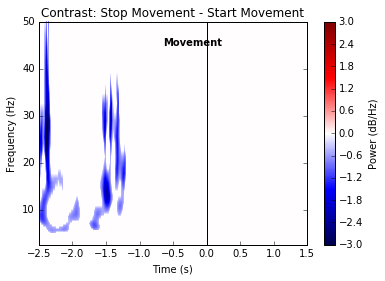

In [10]:
%%time
contrast1, fig = significant_time_frequency(dbname, tuplist, ['stops_free', 'starts'], 
                                           Tpre, Tpost,
                                           freqs, thresh, normfun=nf, niter=niter, 
                                           rasterized=True, cmap='seismic', clim=clim);

# decorations
plt.axvline(x=0, color='k')
plt.text(-0.65, 45, 'Movement', fontweight='bold')

plt.title('Contrast: Stop Movement - Start Movement')

plt.tick_params(axis='x', which='both', top='off');

# Contrast voluntary and involuntary stops

In [11]:
%%time
contrast2, fig = significant_time_frequency(dbname, tuplist, ['stops_free', 'stops_control'], Tpre, Tpost,
                           freqs, thresh, normfun=nf, niter=niter, 
                           rasterized=True, cmap='seismic', clim=clim);

# decorations
plt.axvline(x=0, color='k')
plt.text(0.05, 45, 'Stop', fontweight='bold')

plt.title('Contrast: Free Stop - Forced Stop')

plt.tick_params(axis='x', which='both', top='off');

(11, 1)
(14, 2)
(14, 1)
(12, 1)
(15, 1)
(16, 1)
(16, 2)
(17, 1)
Dataset (11, 1) has no events of type stops_controlDataset (14, 2) has no events of type stops_controlDataset (14, 1) has no events of type stops_controlDataset (12, 1) has no events of type stops_controlDataset (15, 1) has no events of type stops_controlDataset (16, 1) has no events of type stops_controlDataset (16, 2) has no events of type stops_controlDataset (17, 1) has no events of type stops_control







(23, 1)
(20, 1)
(21, 1)
(18, 1)
(24, 1)
(22, 1)
(25, 1)
(17, 2)
Dataset (17, 2) has no events of type stops_controlDataset (18, 1) has no events of type stops_control

(30, 1)


ValueError: all the input arrays must have same number of dimensions

In [ ]:
%debug

> /Users/jmxp/code/bart_analysis/time_frequency_helpers.py(228)get_spectra_and_labels()
    227 
--> 228     spectra = np.concatenate(spectra_list)
    229     labels = np.concatenate(labels_list)

ipdb> len(spectra_list)
17
ipdb> spectra_list
([], [], [], [], [], [], [], [], [], [], [array([[-0.03593724, -0.03755716, -0.03741081, ..., -0.09325573,
        -0.09508764, -0.08831748],
       [-0.03679841, -0.03853087, -0.03845905, ..., -0.08275624,
        -0.08373681, -0.07988936],
       [-0.03765998, -0.03950599, -0.03950994, ..., -0.06495098,
        -0.06347623, -0.06153832],
       ..., 
       [-0.01781492, -0.02141767, -0.02492185, ..., -0.5175806 ,
        -0.49894781, -0.42687938],
       [-0.01770868, -0.02129338, -0.02478015, ..., -0.75837825,
        -0.74881789, -0.65578641],
       [-0.01759397, -0.02115659, -0.02462099, ..., -0.88206091,
        -0.87896927, -0.78511053]]), array([[-0.05214328, -0.05996392, -0.06655932, ..., -0.40586968,
        -0.41275563, -0.38316524],